<a href="https://colab.research.google.com/github/Korzhinho/Test/blob/master/prompts_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install wordfreq
%pip install transformers
%pip install pycountry
%pip install countryinfo
%pip install pyspellchecker
%pip install openpyxl
%pip install nltk
%pip install toloka-kit

In [ ]:
import pandas as pd
import numpy as np
import wordfreq
from wordfreq import zipf_frequency
from wordfreq import tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import pipeline
import pycountry
from countryinfo import CountryInfo
from spellchecker import SpellChecker
import nltk
from nltk.corpus import stopwords
import openpyxl
import toloka.client as toloka
from google.colab import drive
drive.mount('/content/drive')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
token = '<TOLOKA_TOKEN>'
toloka_client = toloka.TolokaClient(
    token, 'PRODUCTION')

In [ ]:
def get_prompts(project_ids):
  df = pd.DataFrame()

  for project in project_ids:
    pools = []
    for pool in toloka_client.get_pools(project_id=project, status='OPEN'):
      pools.append(pool.id)
    for pool in toloka_client.get_pools(project_id=project, status='CLOSED'):
      pools.append(pool.id)

    for pool in pools:
      for assignment in toloka_client.get_assignments(
          pool_id=pool,
          status='ACCEPTED'
          ):
        new_row = {}
        new_row['prompt'] = assignment.solutions[0].output_values['prompt']
        new_row['user_id'] = assignment.user_id
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

  return df

def get_user_country(user_id):
  user = toloka_client.get_user(user_id)
  country = user.attributes.country_by_phone

  return country

def get_region(country):
    try:
      region = CountryInfo(country).region()

      return region
    except (KeyError):
      pass

def get_subregion(country):
    try:
      subregion = CountryInfo(country).subregion()

      return subregion
    except (KeyError):
      pass

projects = ['146760', '146761', '146912', '147274']
# projects = ['146760', '146761']
df = get_prompts(projects)

df['country_code'] = df['user_id'].apply(get_user_country)
df['country'] = df['country_code'].apply(lambda x: pycountry.countries.get(alpha_2=x).name)

df = df.replace(to_replace="Taiwan, Province of China", value="Taiwan")
df = df.replace(to_replace="Viet Nam", value="Vietnam")

In [ ]:
l = df['country'].unique()
countries = pd.DataFrame({'country': l})
countries = countries.replace(to_replace="Moldova, Republic of", value="Moldova")
countries = countries.replace(to_replace="Venezuela, Bolivarian Republic of", value="Venezuela")
countries['region'] = countries['country'].apply(lambda x: get_region(x))
countries['subregion'] = countries['country'].apply(lambda x: get_subregion(x))
df = pd.merge(df, countries, on='country', how='left')

users = pd.read_excel('drive/MyDrive/Toloka/llm/sft/users.xls')
users = users[['user_id', 'age']]
df = pd.merge(df, users, on='user_id', how='left')

df['age_group'] = pd.cut(df['age'], bins=[18, 24, 34, 44, 54, 64, 74, 110], labels=['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+'])

In [ ]:
topic = pipeline("text-classification", model="cardiffnlp/tweet-topic-21-multi", tokenizer="cardiffnlp/tweet-topic-21-multi", max_length=512, truncation=True)
df['topic'] = df['prompt'].apply(topic).apply(lambda x: x[0]['label'])

In [ ]:
# df.to_csv('drive/MyDrive/Toloka/llm/prompts_info.tsv', index=False)

In [ ]:
# df = pd.read_csv('drive/MyDrive/Toloka/llm/marketing/prompts_info.tsv', sep='\t', encoding='utf8')
# df['prompt'] = df['prompt'].astype(str).apply(openpyxl.utils.escape.unescape) # https://stackoverflow.com/questions/74863976/removing-x000d-from-text-records-in-pandas-dataframe

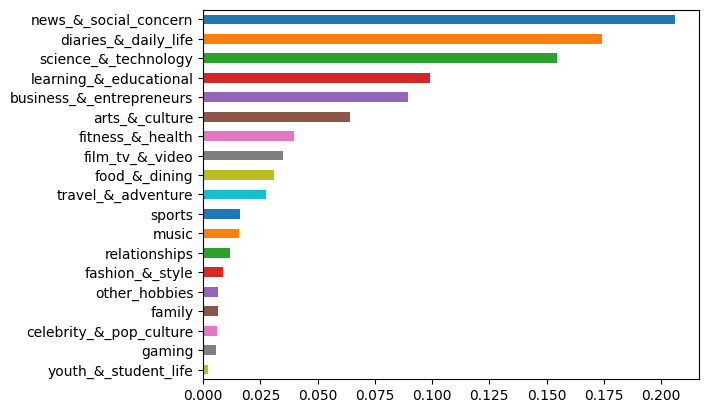

In [ ]:
cmap = plt.cm.tab10
colors = cmap(np.arange(len(df)) % cmap.N)
plot = df['topic'].value_counts(normalize=True).plot.barh(color=colors).invert_yaxis()

In [ ]:
df2 = df.drop_duplicates(subset=['user_id'])
len(df2)

1038

In [ ]:
df2 = df2.drop(df2[df2['country'] == 'Kenya'].sample(frac=0.6).index)
len(df2)

860

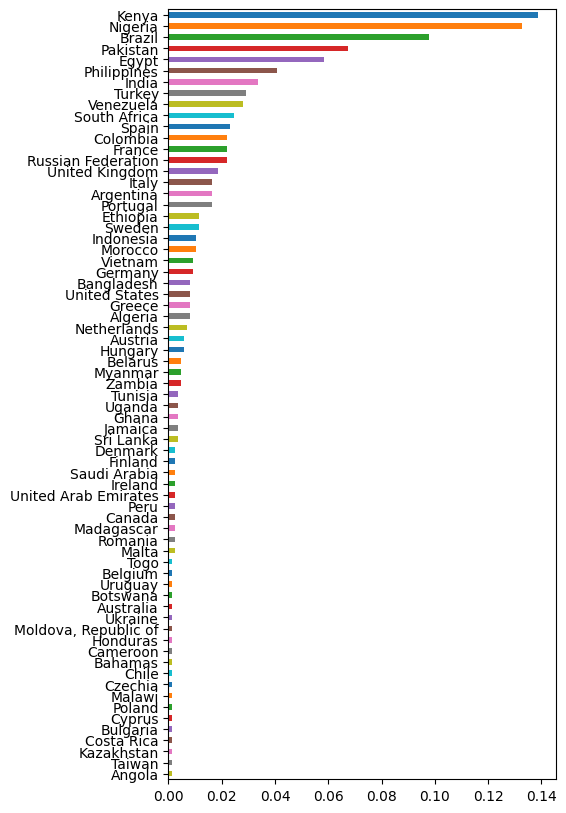

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(5,10))
colors = cmap(np.arange(len(df)) % cmap.N)
plot = df2['country'].value_counts(normalize=True).plot.barh(color=colors).invert_yaxis()

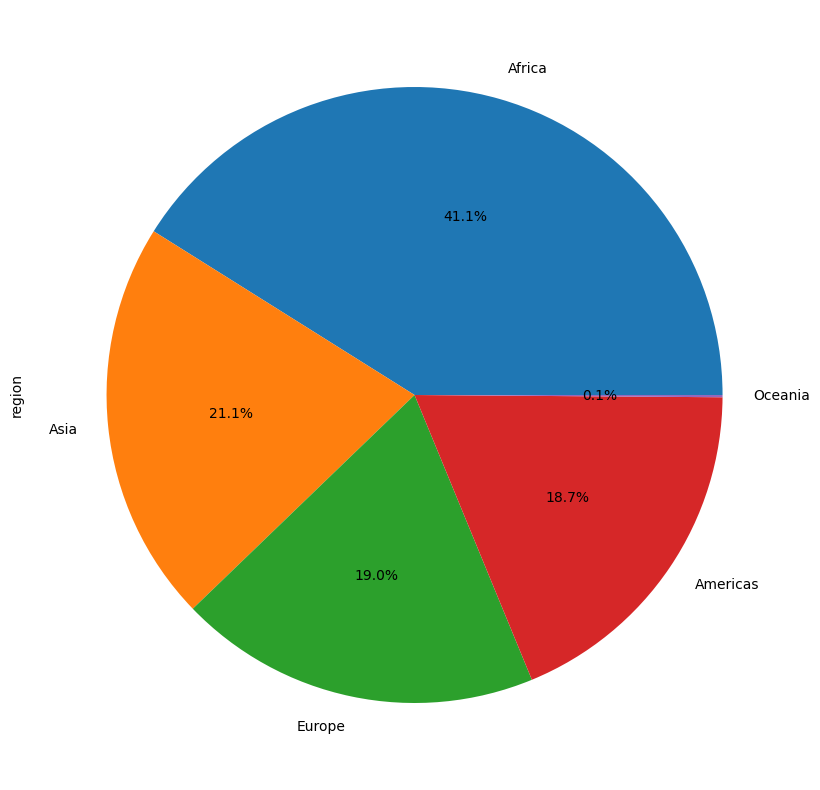

In [ ]:
plt.figure(figsize=(10, 10))
plot = df2['region'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%')

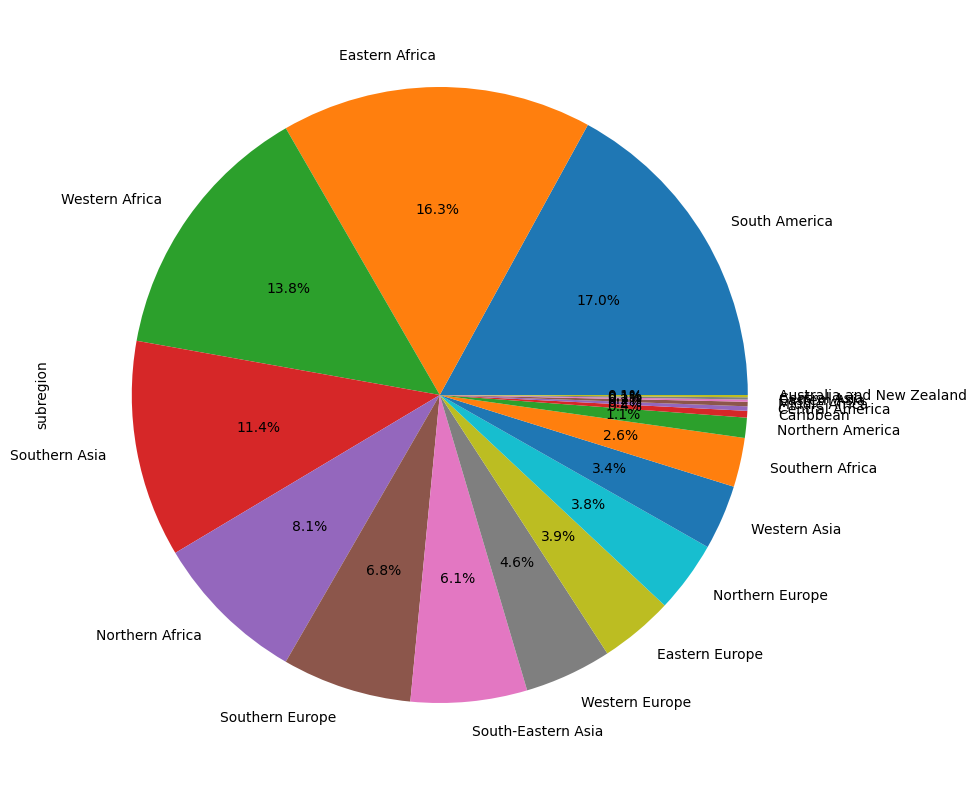

In [ ]:
plt.figure(figsize=(10, 10))
plot = df2['subregion'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%')

In [ ]:
df1 = df.groupby('subregion')['topic'].value_counts(normalize=True).reset_index(name='percentage')

In [ ]:
df1['percentage'] = df1['percentage'].mul(100).round(1).astype(str) + '%'

In [ ]:
df1

,subregion,topic,percentage
0,Australia and New Zealand,diaries_&_daily_life,100.0%
1,Caribbean,news_&_social_concern,52.0%
2,Caribbean,diaries_&_daily_life,16.0%
3,Caribbean,science_&_technology,16.0%
4,Caribbean,learning_&_educational,12.0%
...,...,...,...
242,Western Europe,travel_&_adventure,1.4%
243,Western Europe,gaming,0.9%
244,Western Europe,music,0.9%
245,Western Europe,fashion_&_style,0.5%


In [ ]:
# df1.to_csv('drive/MyDrive/Toloka/llm/marketing/topics_by_subregion.tsv', index=False)

In [ ]:
def rarest_words(text, top_n=10):
  tokens = tokenize(text, 'en')
  words_zipf = {}
  for token in tokens:
    freq = zipf_frequency(token, 'en')
    if token not in words_zipf and token.isalpha() and freq > 0:
      words_zipf[token] = 1-freq # inverted for wordcloud

  rarest_tuples = sorted(words_zipf.items(), key=lambda x: x[1], reverse=True)[:top_n]
  rarest_dict = dict((x, y) for x, y in rarest_tuples)

  return rarest_dict

spell = SpellChecker()

def fix_spelling(word_list):
  misspelled = spell.unknown(word_list)
  fixed_words = []
  remove_list = []
  for word in misspelled:
    fixed_word = spell.correction(word)
    if fixed_word is not None:
      fixed_words.append(fixed_word)
    remove_list.append(word)

    res = word_list + fixed_words

    result = [i for i in res if i not in remove_list]

  return result

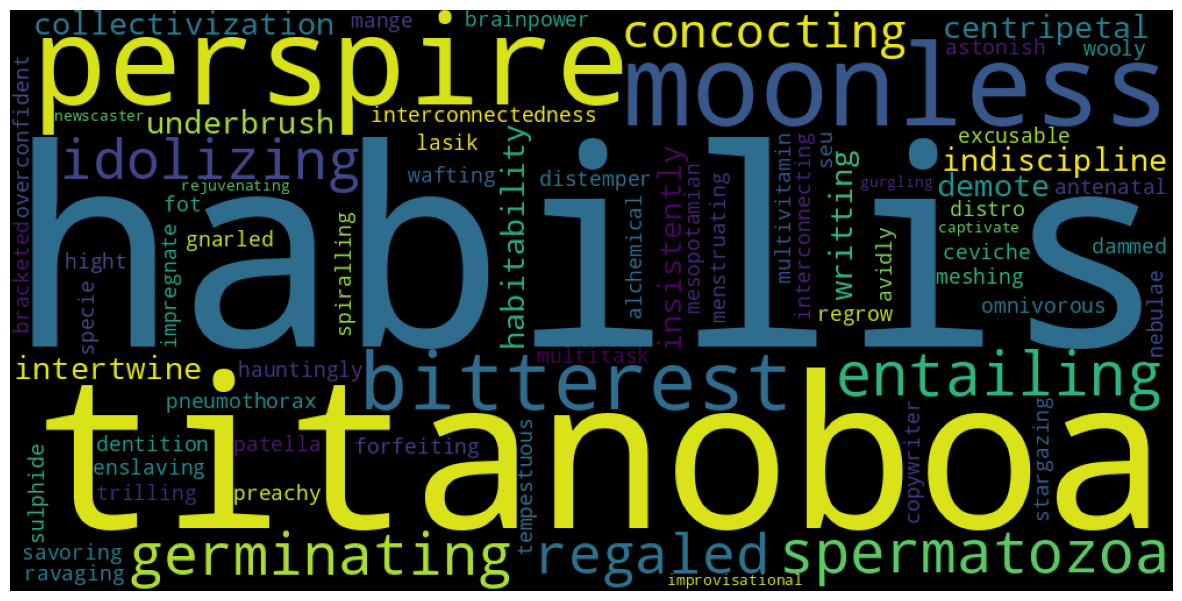

In [ ]:
spell = SpellChecker()

def fix_spelling(word_list):
  misspelled = spell.unknown(word_list)
  fixed_words = []
  remove_list = []
  for word in misspelled:
    fixed_word = spell.correction(word)
    if fixed_word is not None:
      fixed_words.append(fixed_word)
    remove_list.append(word)
    res = word_list + fixed_words
    result = [i for i in res if i not in remove_list]

  return result

def rarest_zipf(text, top_n, lang='en'):
  tokens = tokenize(text, lang)
  zipf_dict = {}
  for token in tokens:
    freq = zipf_frequency(token, lang)
    if token not in zipf_dict and token.isalpha() and freq > 0:
      zipf_dict[token] = 1-freq # inverted for wordcloud

  rarest_tuples = sorted(zipf_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
  rarest_dict = dict((x, y) for x, y in rarest_tuples)

  return rarest_dict

def rare_words(df, top_n=200):
  vocab = list(set(' '.join([i for i in df['prompt'].astype(str)]).split()))
  text = ' '.join([i for i in vocab])
  candidates = list(rarest_zipf(text, top_n+300))
  fixed_vocab = fix_spelling(candidates)
  text_fixed = ' '.join([i for i in fixed_vocab])
  rare_dict = rarest_zipf(text_fixed, top_n)

  rare_dict = {k: v for k, v in rare_dict.items() if ((k in vocab) and (nltk.tag.pos_tag([k])[0][1] != 'NNS'))}

  return rare_dict

word_cloud_dict = rare_words(df, 200)

blacklist = ['shold', 'llegar', 'rocka', 'wite', 'puede', 'problema',
             'paisa', 'tive', 'trou', 'theis', 'hace', 'sixtieth',
             'ticktock', 'hemothorax', 'trully', 'gravedigger',
             'necrophilic', 'creat', 'maior', 'programing']

word_cloud_dict_whitelisted = {key:val for key, val in word_cloud_dict.items() if key not in blacklist}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict_whitelisted)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


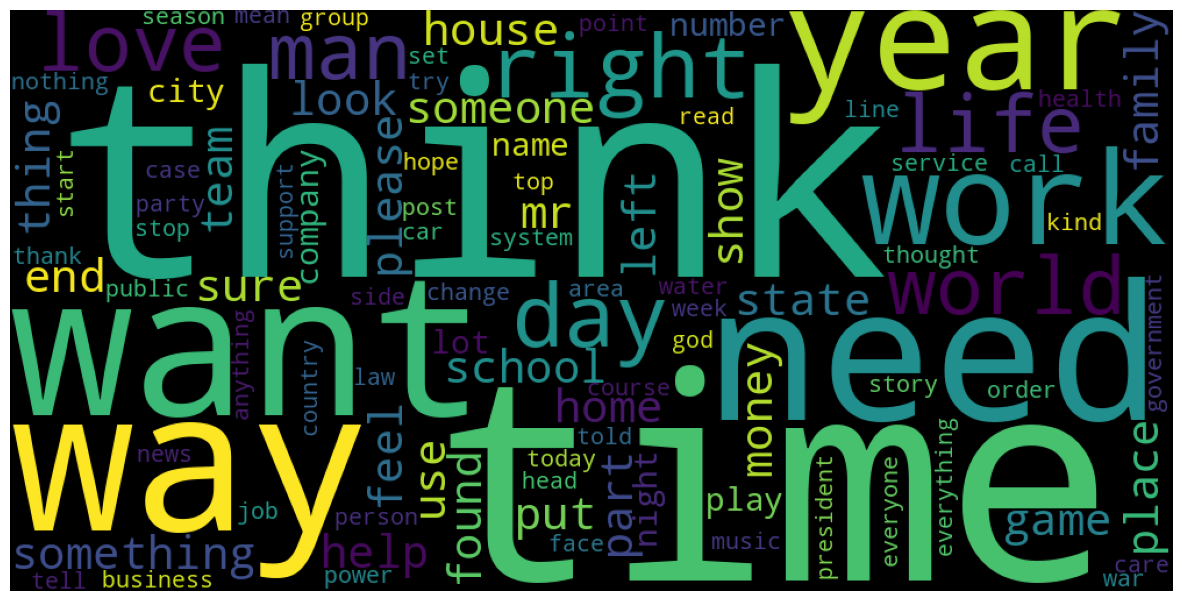

In [ ]:
# popular words

stop_words = set(stopwords.words('english'))

def popular_words(df, top_n=10):
  vocab = list(set(' '.join([i for i in df['prompt'].astype(str)]).split()))
  text = ' '.join([i for i in vocab])

  tokens = tokenize(text, 'en')
  words_zipf = {}
  for token in tokens:
    freq = zipf_frequency(token, 'en')
    if ((token not in words_zipf and token.isalpha())
     and (freq > 0) and (token.lower() not in stop_words)
      and (nltk.tag.pos_tag([token])[0][1] in ['NN', 'ADJ', 'ADV'])):
      words_zipf[token] = freq

  popular_tuples = sorted(words_zipf.items(), key=lambda x: x[1], reverse=True)[:top_n]
  popular_dict = dict((x, y) for x, y in popular_tuples)

  return popular_dict

word_cloud_dict = popular_words(df, 100)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

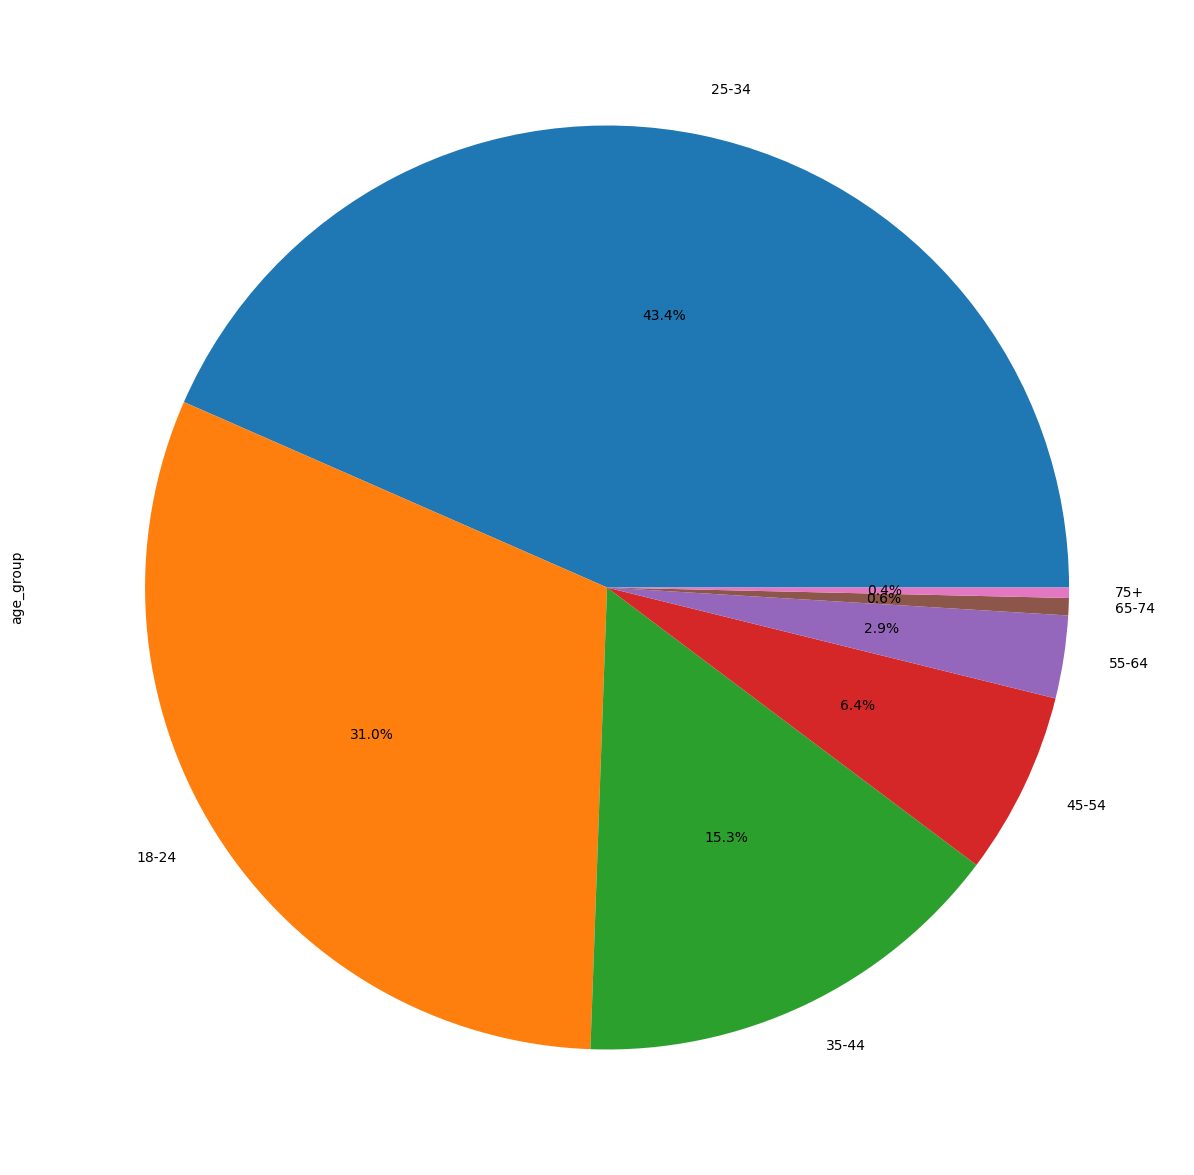

In [ ]:
plt.figure(figsize=(15, 15))
plot = df2['age_group'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%')

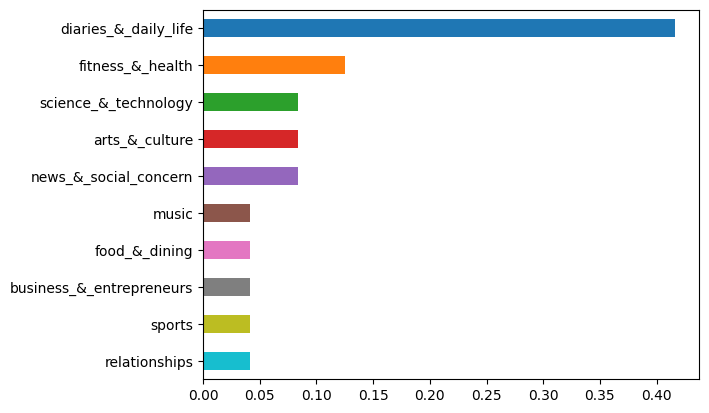

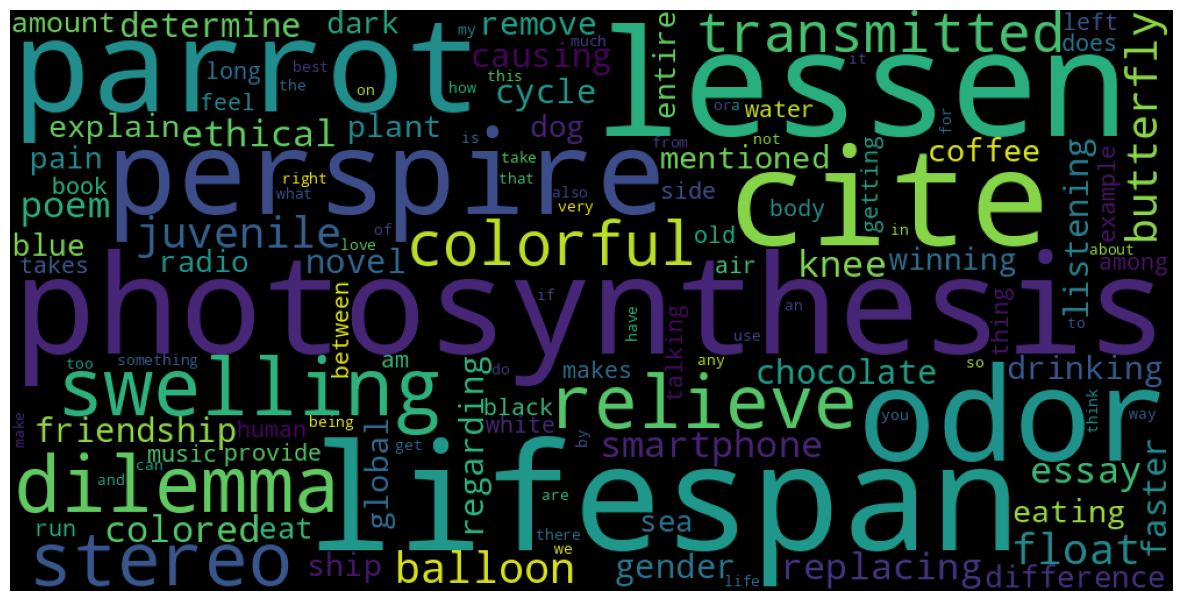

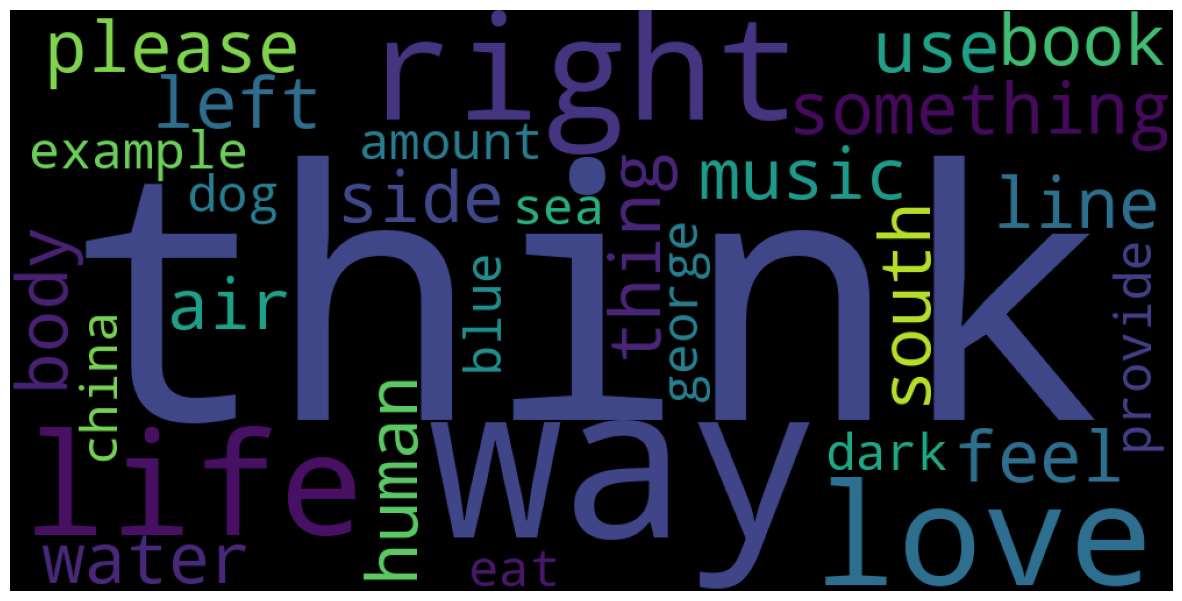

In [ ]:
# demogpraphic filters
age_group = '55-64'
subregion = 'South-Eastern Asia'

df_demog = df[(df['age_group'] == age_group) & (df['subregion'] == subregion)]
plot = df_demog['topic'].value_counts(normalize=True).plot.barh(color=colors).invert_yaxis()


# rare words
word_cloud_dict = rare_words(df_demog, 200)

blacklist = ['shold', 'llegar', 'rocka', 'wite', 'puede', 'problema',
             'paisa', 'tive', 'trou', 'theis', 'hace', 'sixtieth',
             'ticktock', 'hemothorax', 'trully', 'gravedigger',
             'necrophilic', 'creat', 'maior', 'programing']

word_cloud_dict_whitelisted = {key:val for key, val in word_cloud_dict.items() if key not in blacklist}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict_whitelisted)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# popular words
word_cloud_dict = popular_words(df_demog, 30)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()